In [2]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
import pickle #.
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from tensorflow.keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-rb6avtwi because the default path (/home/abriza/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [66]:
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-success">
    
* Original parent directory: "../../storage/"
* Implemented parent directory: "./" 
</div>

In [3]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "./image_caption/dataset/TextFiles/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [4]:
#.
type(doc), len(doc)

(str, 3395237)

In [5]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [6]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [7]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [8]:
descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [9]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [10]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [11]:
#. show image


In [12]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [13]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [14]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [15]:
#.
!head descriptions.txt

1000268201_693b08cb0e child in pink dress is climbing up set of stairs in an entry way
1000268201_693b08cb0e girl going into wooden building
1000268201_693b08cb0e little girl climbing into wooden playhouse
1000268201_693b08cb0e little girl climbing the stairs to her playhouse
1000268201_693b08cb0e little girl in pink dress going into wooden cabin
1001773457_577c3a7d70 black dog and spotted dog are fighting
1001773457_577c3a7d70 black dog and tricolored dog playing with each other on the road
1001773457_577c3a7d70 black dog and white dog with brown spots are staring at each other in the street
1001773457_577c3a7d70 two dogs of different breeds looking at each other on the road
1001773457_577c3a7d70 two dogs on pavement moving toward each other


In [16]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = './image_caption/dataset/TextFiles/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [17]:
#. train is a set of photo identifiers
list(train)[:5]

['2735290454_1bd8bc5eac',
 '3230132205_dccfafa5ee',
 '3530504007_3272c57e21',
 '2130203183_49bae96b96',
 '3345025842_bc2082a509']

In [18]:
# Below path contains all the images
images = './image_caption/dataset/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [19]:
#.
type(img), len(img), img[:3]

(list,
 8091,
 ['./image_caption/dataset/Flicker8k_Dataset/1053804096_ad278b25f1.jpg',
  './image_caption/dataset/Flicker8k_Dataset/110595925_f3395c8bd6.jpg',
  './image_caption/dataset/Flicker8k_Dataset/1236951314_0308dc4138.jpg'])

In [20]:
# Below file contains the names of images to be used in train data
train_images_file = './image_caption/dataset/TextFiles/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [21]:
#. 
len(train_img), train_img[:3]

(6000,
 ['./image_caption/dataset/Flicker8k_Dataset/1053804096_ad278b25f1.jpg',
  './image_caption/dataset/Flicker8k_Dataset/110595925_f3395c8bd6.jpg',
  './image_caption/dataset/Flicker8k_Dataset/1236951314_0308dc4138.jpg'])

In [22]:
# Below file conatins the names of images to be used in test data
test_images_file = './image_caption/dataset/TextFiles/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [23]:
#. 
len(test_img), test_img[:3]

(1000,
 ['./image_caption/dataset/Flicker8k_Dataset/2073105823_6dacade004.jpg',
  './image_caption/dataset/Flicker8k_Dataset/2682382530_f9f8fd1e89.jpg',
  './image_caption/dataset/Flicker8k_Dataset/279728508_6bd7281f3c.jpg'])

In [24]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [25]:
type(train_descriptions), list(train_descriptions.keys())[0], list(train_descriptions.values())[0]

(dict,
 '1000268201_693b08cb0e',
 ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'])

<div class="alert alert-success">
Note the addition of 'startseq' and 'endseq' in each description/caption
</div>

In [26]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [27]:
#. preprocess a sample image
sample_x = preprocess('./image_caption/dataset/Flicker8k_Dataset/2073105823_6dacade004.jpg')
type(sample_x), sample_x.shape

(numpy.ndarray, (1, 299, 299, 3))

<div class="alert alert-success">
Not sure why axis has to be expanded
</div>

## Transfer Learning Via Inception

In [28]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

2022-03-14 22:19:29.571193: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-14 22:19:29.571249: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-03-14 22:19:29.571500: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


![Inception](https://miro.medium.com/max/1400/1*9VoYufkvd-hBxK3p2NEWmw.png)

In [29]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output) #. get output of the 2nd to the last layer

In [30]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image #. get matrix representation of image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    #. images is the parent path of all image files; img[len(images):] is the identifier for the image 'img'
    encoding_train[img[len(images):]] = encode(img) 
print("Time taken in seconds =", time()-start)

In [ ]:
type(encoding_train), list(encoding_train.keys())[:3]

In [ ]:
k = list(encoding_train.keys())[0] #. get first key
encoding_train[k], encoding_train[k].shape

In [ ]:
# Save the bottleneck train features to disk
with open("./image_caption/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [61]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 119.76768565177917


In [62]:
# Save the bottleneck test features to disk
with open("./image_caption/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

<div class="alert alert-success">
Load saved encoding
</div>

In [32]:
train_features = load(open("./Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [33]:
#.
type(train_features), list(train_features.keys())[:3]

(dict,
 ['1053804096_ad278b25f1.jpg',
  '110595925_f3395c8bd6.jpg',
  '1236951314_0308dc4138.jpg'])

In [34]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

<div class="alert alert-success">
3000 = 6000 images * 5 captions/image
</div>

In [35]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


### <font style="color:green">Create dictionaries for word <--> index conversion</font>

In [36]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [37]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

### <font style="color:green">Compute maximum length (number of words) of captions</font>

In [38]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [39]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [40]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator_tuple2(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ((array(X1), array(X2)), array(y))  #. corrected this portion from list to tuples
                X1, X2, y = list(), list(), list()
                n=0

In [41]:
# Load Glove vectors
glove_dir = './glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [42]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:  #. unused variable max_words
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [43]:
embedding_matrix.shape

(1652, 200)

In [44]:
print(list(wordtoix.keys())[:25])

['startseq', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'an', 'way', 'endseq', 'girl', 'going', 'into', 'wooden', 'building', 'little', 'the', 'to', 'her', 'black', 'dog']


In [45]:
e1, e2, e3 = embeddings_index.get('startseq'), embeddings_index.get('endseq'), embeddings_index.get('child')
e1, e2, e3.shape, e3[-20:], 

(None,
 None,
 (200,),
 array([ 1.2631  , -0.40756 , -0.12467 , -0.16687 , -0.57797 , -0.29546 ,
         0.051005, -0.065237,  0.11431 ,  0.15512 , -0.5127  , -0.58248 ,
         0.19001 ,  0.42882 ,  0.13797 , -0.93658 ,  0.12788 , -0.55435 ,
        -0.57478 , -0.013045], dtype=float32))

In [46]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [47]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [48]:
model.layers[2]

<div class="alert alert-success">
set embedding layer for image as nontrainable
</div>

In [49]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [50]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [50]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [51]:
for i in range(epochs):
    generator = data_generator_tuple2(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5') #. no need to save

/home/phd/abriza/.conda/envs/dla2/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-03-14 17:27:54.504217: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2000/2000 [==============================] - 386s 193ms/step - loss: 2.7294


In [53]:
for i in range(epochs):
    generator = data_generator_tuple2(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')  #. no need to save

2000/2000 [==============================] - 384s 192ms/step - loss: 2.5383


In [54]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [55]:
for i in range(epochs):
    generator = data_generator_tuple2(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

1000/1000 [==============================] - 260s 260ms/step - loss: 2.3849


In [56]:
model.save_weights('./model_weights/model_30.h5')

<div class="alert alert-success">
Load the saved weights
</div>

In [51]:
model.load_weights('./model_weights/model_30.h5')

In [52]:
images = './image_caption/dataset/Flicker8k_Dataset/' #. parent directory of images

In [54]:
with open("./Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [55]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [56]:
#. initialize z as index to our images
z = -1

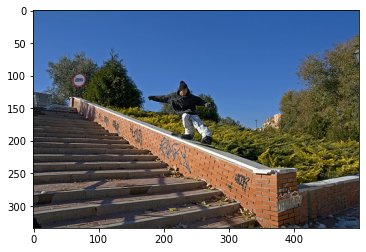

2022-03-14 22:21:41.639607: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Greedy: man and woman sit on bench


In [57]:
z+=1  #.get next image
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

<div class="alert alert-success">
<h2>Implement Bleu to Evaluate Caption Effectiveness</h2>
</div>

In [58]:
from nltk.translate.bleu_score import sentence_bleu

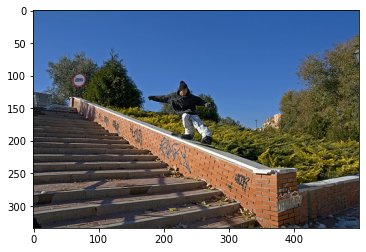

In [59]:
z = 0
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)

In [60]:
image_filename = list(encoding_test.keys())[z]
image_id = image_filename[:-4]
image_id

'2073105823_6dacade004'

In [61]:
captions = descriptions[image_id]
captions

['man in black hoodie and jeans skateboards down railing',
 'man skateboards down steep railing next to some steps',
 'person is sliding down brick rail on snowboard',
 'person walks down the brick railing near set of steps',
 'snowboarder rides down handrail without snow']

In [62]:
refs = [caption.split(' ') for caption in captions]
print(refs)

[['man', 'in', 'black', 'hoodie', 'and', 'jeans', 'skateboards', 'down', 'railing'], ['man', 'skateboards', 'down', 'steep', 'railing', 'next', 'to', 'some', 'steps'], ['person', 'is', 'sliding', 'down', 'brick', 'rail', 'on', 'snowboard'], ['person', 'walks', 'down', 'the', 'brick', 'railing', 'near', 'set', 'of', 'steps'], ['snowboarder', 'rides', 'down', 'handrail', 'without', 'snow']]


In [63]:
model_caption = greedySearch(image)
model_caption

'man and woman sit on bench'

In [64]:
candidate = model_caption.split(' ')
candidate

['man', 'and', 'woman', 'sit', 'on', 'bench']

In [78]:
bleu4 = sentence_bleu(refs, candidate)
bleu4

1.5319719891192393e-231

In [77]:
bleu2 = sentence_bleu(refs, candidate, weights=(1./2., 1./2.))
bleu2

1.0547686614863434e-154

In [ ]:
# two references for one document
references = [[['this', 'is', 'a', 'test'], ['this', 'is' 'test']]]
candidates = [['this', 'is', 'a', 'test']]
score = sentence_bleu(references, candidates)
print(score)

<div class="alert alert-success">
<h2>Generate 30 Random Images and Calculate Bleu2 from 2 References</h2>
</div>

In [93]:
def calc_bleu(z, model_caption, nrefs=2):
    """ returns bleu2 score and caption references
    """
    image_filename = list(encoding_test.keys())[z]
    image_id = image_filename[:-4]
    captions = descriptions[image_id] 
    refs = [caption.split(' ') for caption in captions[:nrefs]] #.get only nrefs captions
    candidate = model_caption.split(' ')
    bleu2 = sentence_bleu(refs, candidate, weights=(1./2., 1./2.))
    return bleu2, captions

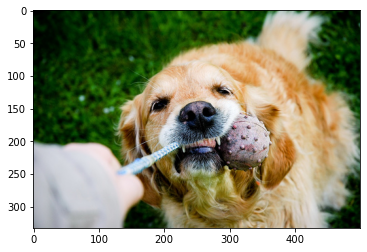

Model caption: dog is running through the water
BLEU: 5.1548279763727125e-155
Ref caption1: dog bites an object offered by person
Ref caption2: dog playing with dog toy as someone tries to pull it from its mouth
Ref caption3: golden retriever plays with toy
Ref caption4: the photographer is playing tugofwar with dog
Ref caption5: two dogs fighting for the same chew toy


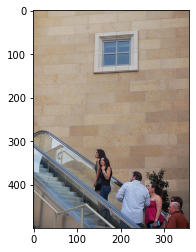

Model caption: two people are sitting on bench in front of fountain
BLEU: 0.18257418583505533
Ref caption1: people are standing on an escalator moving up
Ref caption2: people go up the escalator
Ref caption3: people ride up an escalator
Ref caption4: people travel up the elevator together
Ref caption5: several people ride up an escalator


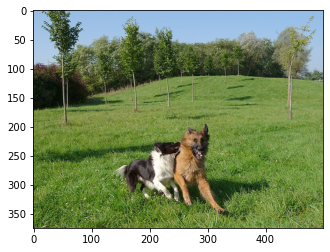

Model caption: two dogs are running through field
BLEU: 0.27486404118222657
Ref caption1: brown dog and black and white dog are running over grassy hills
Ref caption2: two dogs are running next to each other on grassy hill
Ref caption3: two dogs in motion in grassy field with small trees
Ref caption4: two dogs play in field
Ref caption5: two dogs running through field


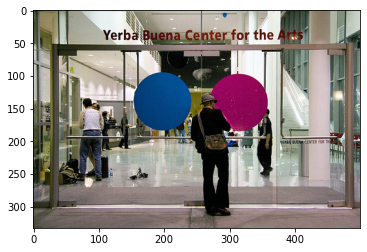

Model caption: man in black shirt and blue jeans is standing in front of large building
BLEU: 0.41931393468876726
Ref caption1: man is standing in front of glass doors with blue spot and pink spot
Ref caption2: man is standing outside the glass doors of an art center
Ref caption3: man stands at the entrance of yerba buena center for the arts
Ref caption4: man walking through glass double doors
Ref caption5: person standing at glass doors with big blue circle and big pink circle


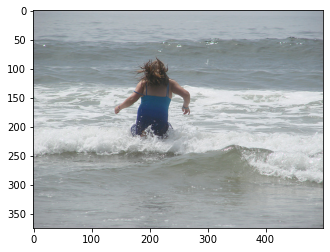

Model caption: young girl in red bathing suit is in the ocean
BLEU: 0.2981423969999719
Ref caption1: girl in blue swimsuit walks into the ocean
Ref caption2: woman running into surf
Ref caption3: woman walking into the waves
Ref caption4: girl is wading through the gray ocean
Ref caption5: woman in blue bathing suit going into the water


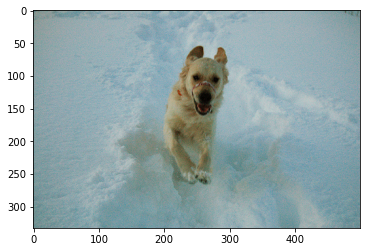

Model caption: dog running through the snow
BLEU: 0.5789300674674098
Ref caption1: dog is playing in the deep snow
Ref caption2: dog running through deep snow pack
Ref caption3: dog runs through the deep snow
Ref caption4: white dog is running through the snow
Ref caption5: white dog running through snow


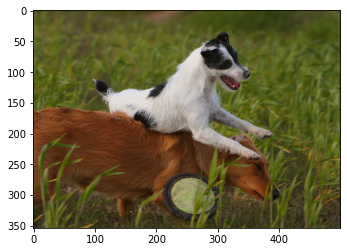

Model caption: two dogs are playing with ball in the grass
BLEU: 6.29232312294398e-155
Ref caption1: little white and black dog is leaping over big brown dog head in field of green grass
Ref caption2: small dog lands on big dog trying to get disc
Ref caption3: small white dogs leaps over the back of larger dog to chase his toy
Ref caption4: two dogs are playing in field of tall grass
Ref caption5: white and black dog jumping over red haired dog in grass


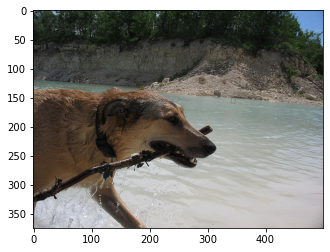

Model caption: brown dog is running through the water
BLEU: 9.765260274142007e-155
Ref caption1: dog carrying stick while walking in water
Ref caption2: dog with stick in his mouth walking through water
Ref caption3: large brown dog with stick in his mouth coming out of water
Ref caption4: wet dog carrying stick in its mouth
Ref caption5: dog retrieving stick in water


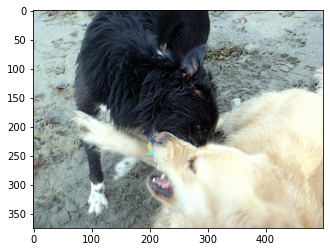

Model caption: black dog is running through the grass
BLEU: 0.26726124191242434
Ref caption1: black dog and tan dog fighting
Ref caption2: black dog and white dog are wrestling on the ground
Ref caption3: black dog bites white dog while standing on the sand
Ref caption4: two dogs fight
Ref caption5: two dogs one white and one black play with each other in the sand


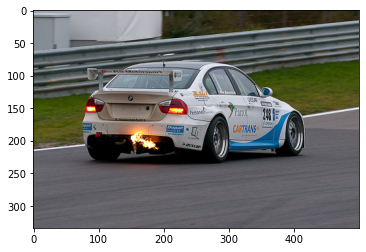

Model caption: race car driver is being ridden by two tires
BLEU: 0.16666666666666669
Ref caption1: race cars muffler catches on fire
Ref caption2: race car sparks
Ref caption3: sports car with flames coming out the exhaust
Ref caption4: the blue and white race car has flames coming out of its tail pipe
Ref caption5: the white racing car has fire bursting from its exhaust pipe


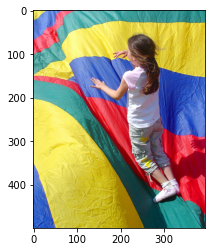

Model caption: two children are playing in blow
BLEU: 6.08970970641905e-155
Ref caption1: girl bouncing on colorful sheet
Ref caption2: girl in bounce house
Ref caption3: girl playing on parachute
Ref caption4: the little girl is playing with her shoes off
Ref caption5: this girl is playing on an object which is yellow green red and blue


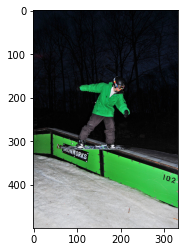

Model caption: snowboarder in red jacket is jumping over barrel
BLEU: 5.273843307431707e-155
Ref caption1: helmeted boy flies through the air on snowboard
Ref caption2: snowboarder balancing on wall
Ref caption3: snowboarder in green grinds along the edge of rail at night
Ref caption4: snowboarder wearing green jacket jumping green rainling
Ref caption5: snowboarder wearing green jacket jumps above low gate


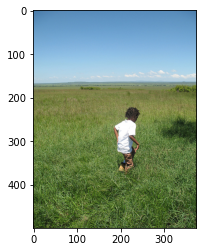

Model caption: young girl in pink dress is walking through grassy field
BLEU: 0.3333333333333333
Ref caption1: child in white shirt and brown pants is walking through an uncut field
Ref caption2: child wearing white shirt is walking through the green grass
Ref caption3: small boy with braids runs through field of tall green grass
Ref caption4: young child runs through large field of grass
Ref caption5: the child is walking through tall grass on sunny day


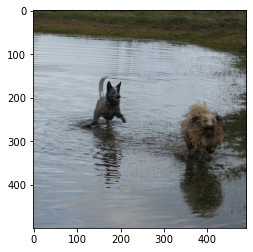

Model caption: dog is running through the water
BLEU: 6.17087516772532e-155
Ref caption1: grey dog chasing brown dog in shallow water
Ref caption2: small black dog chasing small fluffy brown dog just above water
Ref caption3: two dogs moving through water close to the shore
Ref caption4: two dogs playing in lake
Ref caption5: two dogs playing on the shore


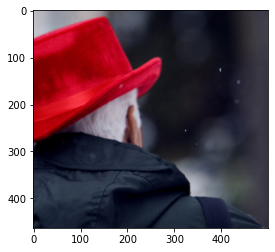

Model caption: man in black shirt and tie hat is holding camera
BLEU: 9.434137710479516e-155
Ref caption1: an older man with white hair blue jacket and bright red hat
Ref caption2: an old man wearing red hat and black raincoat
Ref caption3: an old man with white hair in red hat
Ref caption4: person is red hat and winter jacket is looking into the distance
Ref caption5: person with gray hair wears red hat and watches it snow


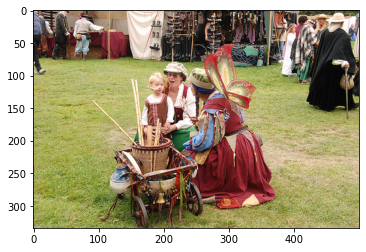

Model caption: group of people are standing around in front of some buildings
BLEU: 0.26967994498529685
Ref caption1: group of people in costume at renaissance fair
Ref caption2: people in costume at renaissance fair
Ref caption3: two woman in colorful costumes look at little girl wearing brown vest
Ref caption4: two women and child are sitting by cart of arrows in front of booth at medieval fayre
Ref caption5: two women crouch near small child at medieval fair


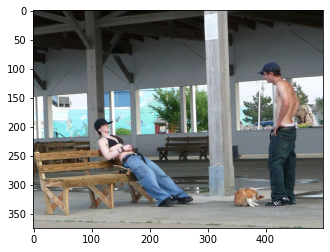

Model caption: two people sit on bench
BLEU: 0.052272098147379334
Ref caption1: shirtless man with brown and white dog looking at woman in jeans and bikini top who is relaxing on bench
Ref caption2: shirtless man with dog next to him talking to shirtless girl slouching on bench
Ref caption3: woman in bikini top is on the bench and man with no shirt is talking to her
Ref caption4: woman is sitting on bench while talking to shirtless man
Ref caption5: woman with hat is sitting on skateboard which is on top of bench and speaking with shirtless man


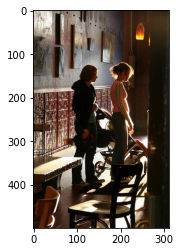

Model caption: man in black shirt and jeans is sitting on bench
BLEU: 4.717068855239749e-155
Ref caption1: two ladies next to stroller inside building
Ref caption2: two woman stand near stroller in dark building
Ref caption3: two women with baby carriage in building next to table and chairs
Ref caption4: two women with baby stroller in fancy restaurant
Ref caption5: two women with strollers standing next to table and chair


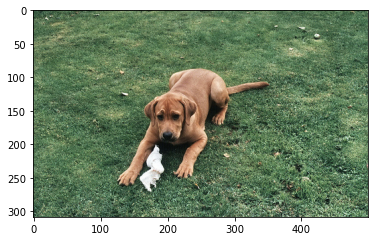

Model caption: brown dog is running through the grass
BLEU: 0.2843113135035004
Ref caption1: brown dog laying in the grass with white chew toy
Ref caption2: brown dog lying in the grass playing with white rag
Ref caption3: brown dog sitting on grass
Ref caption4: dog sitting on grass
Ref caption5: orange dog with knotted white rag on grass


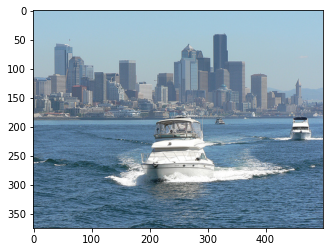

Model caption: man in black is throwing the water
BLEU: 0.26726124191242434
Ref caption1: few boats ride in the water in front of city skyline
Ref caption2: large boat drives through the harbor
Ref caption3: white boat is cruising near large city backdrop
Ref caption4: small yachts in harbor city in background
Ref caption5: there is white boat in the bay with city in the background


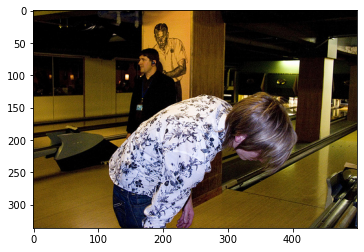

Model caption: two girls are sitting on train
BLEU: 0
Ref caption1: man in flower patterned shirt is bowling
Ref caption2: person bending over to pick up ball at bowling alley
Ref caption3: people at the bowling alley
Ref caption4: the person in the white flowered shirt is bending down at the ball return in the bowling alley
Ref caption5: two people at the bowling alley


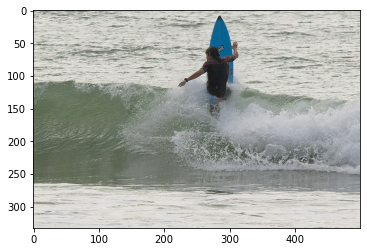

Model caption: man in black wetsuit is surfing on the beach
BLEU: 8.612150057732663e-155
Ref caption1: surfer on blue surfboard is falling off of it as he hits wave
Ref caption2: surfer rides up the wave
Ref caption3: man falling off blue surfboard in the ocean
Ref caption4: the surfer is in the wave
Ref caption5: the surfer rides wave on blue surfboard


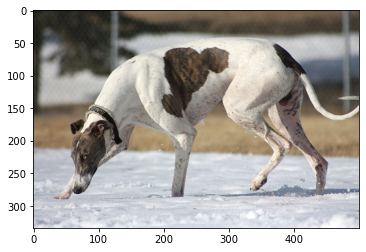

Model caption: dog with red collar runs in the grass
BLEU: 0.18025735467152731
Ref caption1: brown and white dog is sniffing the snow covered ground
Ref caption2: brown and white dog walking in the snow near fence
Ref caption3: brown white greyhound dog sniffs the snow
Ref caption4: lean white and brown dog makes its way through patch of snow
Ref caption5: slender dog checks out snowy patch of land


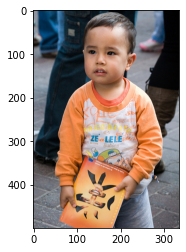

Model caption: little boy in red shirt is sitting on his back in the grass
BLEU: 0.1386750490563073
Ref caption1: child in an orange shirt with book
Ref caption2: young asian boy in orange longsleeved tshirt holds magazine
Ref caption3: young boy is holding book
Ref caption4: the boy wearing an orange sweater is carrying book
Ref caption5: there is child wearing an orange shirt and hold an orange book


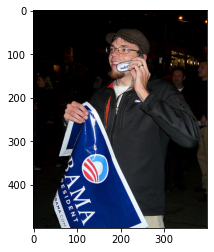

Model caption: man in black shirt and blue shirt is eating
BLEU: 8.612150057732663e-155
Ref caption1: man talking on cellphone is holding blue banner
Ref caption2: man talks on cellphone while holding an obama campaign sign
Ref caption3: the man in glasses carrying an obama poster is talking on cellphone
Ref caption4: the obama supporter wears black jacket and brown hat
Ref caption5: yong man with cellphone and goatee holding obama sign


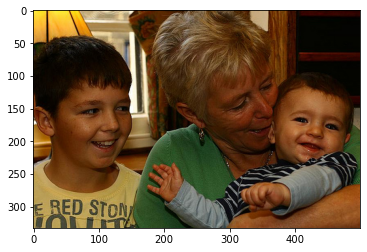

Model caption: two girls are sitting on floral carpet
BLEU: 0
Ref caption1: lady holds little boy while another little boy smiles at them
Ref caption2: an older lady holds toddler while another boy watches
Ref caption3: white woman in green sweater holds smiling child whilst smiling boy in yellow shirt looks on
Ref caption4: woman holds baby while boy sits next to her smiling
Ref caption5: woman holds baby while another child looks on


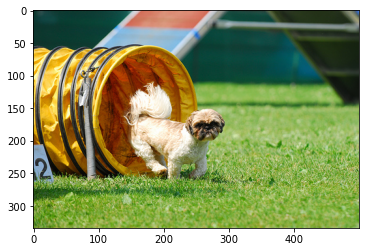

Model caption: two dogs are playing together in the grass
BLEU: 5.273843307431707e-155
Ref caption1: dog coming out of large yellow tube
Ref caption2: little brown and white dog emerges from yellow collapsable toy tunnel onto the lawn
Ref caption3: small dog in front of yellow tube on grass
Ref caption4: small white dog walks through yellow tube
Ref caption5: white dog emerges from yellow tube on an obstacle course


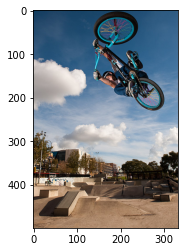

Model caption: man on bmx bike jumps over pile of rocks
BLEU: 7.70649047396433e-155
Ref caption1: man rides his blue bike high in the air over park
Ref caption2: man wearing blue and riding blue bike jumping in midair
Ref caption3: someone is airborne on turquoise bicycle
Ref caption4: the boy is doing stunt through the air on his bicycle
Ref caption5: the man is performing trick high in the air with bicycle


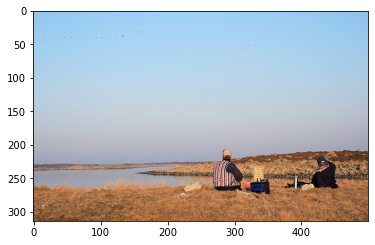

Model caption: two people are sitting on the edge of the beach
BLEU: 0.36614752383039256
Ref caption1: two men sitting on the bank of lake with an ice chest
Ref caption2: two people having picnic by lake
Ref caption3: two people having picnic by the shore
Ref caption4: two people sitting on grass in front of lake looking at the sky
Ref caption5: two people with hats looking at lake while sitting on yellowgrassed hill


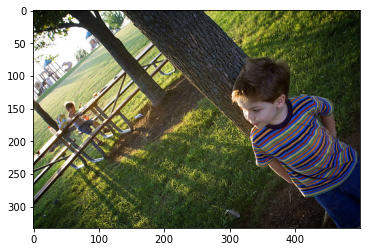

Model caption: little girl in pink dress is jumping off of swing
BLEU: 5.476650797505702e-155
Ref caption1: boy hiding behind tree
Ref caption2: boy in striped tshirt is standing by tree in front of the picnic tables
Ref caption3: little boy in striped shirt is standing behind tree
Ref caption4: young boy in striped shirt is leaning against tree while another child sits at picnic table
Ref caption5: two boys in park one standing near tree and one sitting at picnic table with the playground behind them


In [97]:
import random
for i in range(30):
    z = random.randint(0, len(encoding_test)-1)
    pic = list(encoding_test.keys())[z]
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    model_caption = greedySearch(image)
    bleu2, captions = calc_bleu(z, model_caption, nrefs=2)
    print(f'Model caption: {model_caption}')
    print(f'BLEU: {bleu2}')    
    print(f'Ref caption1: {captions[0]}')
    print(f'Ref caption2: {captions[1]}')
    print(f'Ref caption3: {captions[2]}')
    print(f'Ref caption4: {captions[3]}')
    print(f'Ref caption5: {captions[4]}') 